In [ ]:
#imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from math import sqrt
from hyperopt import hp
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.hyperopt_model import HyperoptModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr,  spearmanr,  kendalltau

In [ ]:
# read the data
preprocessed_data = pd.read_pickle('../data/preprocessed_twitter_Klout.pd')

# Create a dataframe
df = pd.DataFrame(preprocessed_data)

In [ ]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test=train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Cross-validated scores: [  0.53292395 -45.58899754   0.51475603   0.43249178]
Average R^2 score: -11.0272064445


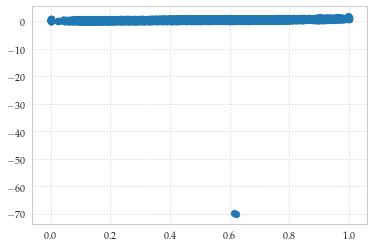

R2Score: -9.30202128836
RMSE: 0.6665069334173382


In [5]:
# Linear Regression 
dfLinear = df.copy()
y = dfLinear['score'].copy()
dfLinear.drop('score', axis=1, inplace=True) 

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(dfLinear, y, test_size=0.2)

model = linear_model.LinearRegression()

scores = cross_val_score(model, dfLinear, y, cv=4)
print("Cross-validated scores:", scores)
print("Average R^2 score:", scores.mean())

predictions = cross_val_predict(model, dfLinear, y, cv=4)
plt.scatter(y, predictions)
plt.show()

accuracy = metrics.r2_score(y, predictions)
print("R2Score:", accuracy)
rmse = sqrt(metrics.mean_squared_error(y,  predictions))
print("RMSE:", rmse)

In [6]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Lasso Regression with hyperopt optimization
    lasso = HyperoptModel(train.copy(), test.copy(),'lasso', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')

    lasso.pipeline = Pipeline([
        ('estimate', linear_model.Lasso(**{'alpha': 0.0006577184991258585}))
    ])
    
    lasso.raw_features = features
    lasso.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 10),
    }

    if hyperopt:
        lasso.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lasso.pipeline.fit(X=lasso.X_train, y=lasso.y_train)
        lasso.model = lasso.pipeline
        lasso.stats()
        lasso.plot_feature_importance()
        lasso.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        lasso.qq_plot()

Stats (train | test):
	R^2 score:		0.5785
					0.5847
	RMSE:			0.1345
					0.1350
	Mean error:		0.1078
					0.1078
	Pearson:		0.7612
					0.7654
	Spearman:		0.7539
					0.7566
	KendallTau:		0.5627
					0.5666

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [7]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Ridge Regression with hyperopt optimization
    ridge = HyperoptModel(train.copy(), test.copy(),'ridge', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')
    ridge.raw_features = features

    ridge.pipeline = Pipeline([
        ('estimate', linear_model.Ridge(**{'alpha': 0.05231780585024858}))
    ])
    
    ridge.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 1000),
    }

    if hyperopt:
        ridge.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        ridge.pipeline.fit(X=ridge.X_train, y=ridge.y_train)
        ridge.model = ridge.pipeline
        ridge.stats()
        ridge.plot_feature_importance()
        ridge.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        ridge.qq_plot()

Stats (train | test):
	R^2 score:		0.5862
					0.5913
	RMSE:			0.1333
					0.1339
	Mean error:		0.1062
					0.1063
	Pearson:		0.7656
					0.7690
	Spearman:		0.7595
					0.7622
	KendallTau:		0.5688
					0.5725

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [8]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run MLPRegressor with hyperopt optimization
    nn = HyperoptModel(train.copy(), test.copy(),'nn', cv=3, max_evals=500)
    features = list(df)
    features.remove('score')
    nn.raw_features = features

    nn.pipeline = Pipeline([
        ('estimate', MLPRegressor())
    ])
   
    nn.space = {
         'estimate__alpha' : hp.uniform('estimate__alpha', 0.001, 1),
         'estimate__activation' : hp.choice('estimate__activation', ['logistic']), # 'identity', 'logistic', 'tanh', 'relu'
         #'estimate__learning_rate' : hp.choice('estimate__learning_rate', ['constant', 'invscaling', 'adaptive']),
         'estimate__hidden_layer_sizes' : scope.int(hp.uniform('estimate__hidden_layer_sizes', 1, 100)),
         'estimate__solver' : hp.choice('estimate__solver', ['adam']), #'lbfgs', 'sgd',
         #'estimate__max_iter' : scope.int(hp.uniform('estimate__max_iter', 500, 1000))
    }

    if hyperopt:
        nn.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        nn.pipeline.fit(X=nn.X_train, y=nn.y_train)
        nn.model = cat.pipeline
        nn.stats()
        nn.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        nn.plot_feature_importance()
        nn.qq_plot()

Performing parameters optimization...
[1/500]	cv_eval_time=21.35 sec	RMSE=0.153470	R^2=0.466424
[2/500]	cv_eval_time=33.95 sec	RMSE=0.151504	R^2=0.461418
[3/500]	cv_eval_time=26.80 sec	RMSE=0.143848	R^2=0.516909
[4/500]	cv_eval_time=16.59 sec	RMSE=0.153067	R^2=0.455675
[5/500]	cv_eval_time=26.81 sec	RMSE=0.144226	R^2=0.510702
[6/500]	cv_eval_time=28.96 sec	RMSE=0.144022	R^2=0.512804
[7/500]	cv_eval_time=19.87 sec	RMSE=0.152064	R^2=0.435782
[8/500]	cv_eval_time=12.58 sec	RMSE=0.146661	R^2=0.501326
[9/500]	cv_eval_time=37.57 sec	RMSE=0.156086	R^2=0.430615
[10/500]	cv_eval_time=19.17 sec	RMSE=0.141222	R^2=0.531637
[11/500]	cv_eval_time=25.45 sec	RMSE=0.137279	R^2=0.563159
[12/500]	cv_eval_time=25.95 sec	RMSE=0.140519	R^2=0.537745
[13/500]	cv_eval_time=21.64 sec	RMSE=0.146773	R^2=0.505534
[14/500]	cv_eval_time=23.53 sec	RMSE=0.145120	R^2=0.504371
[15/500]	cv_eval_time=16.71 sec	RMSE=0.137518	R^2=0.566440
[16/500]	cv_eval_time=13.43 sec	RMSE=0.149379	R^2=0.475581
[17/500]	cv_eval_time=23.54

[139/500]	cv_eval_time=21.42 sec	RMSE=0.136280	R^2=0.559991
[140/500]	cv_eval_time=22.35 sec	RMSE=0.145072	R^2=0.517261
[141/500]	cv_eval_time=25.65 sec	RMSE=0.138847	R^2=0.556622
[142/500]	cv_eval_time=24.76 sec	RMSE=0.139087	R^2=0.553427
[143/500]	cv_eval_time=26.25 sec	RMSE=0.136350	R^2=0.559004
[144/500]	cv_eval_time=25.65 sec	RMSE=0.140698	R^2=0.532287
[145/500]	cv_eval_time=19.07 sec	RMSE=0.135683	R^2=0.570548
[146/500]	cv_eval_time=21.02 sec	RMSE=0.135793	R^2=0.568370
[147/500]	cv_eval_time=23.53 sec	RMSE=0.138043	R^2=0.559460
[148/500]	cv_eval_time=22.24 sec	RMSE=0.136841	R^2=0.553266
[149/500]	cv_eval_time=30.01 sec	RMSE=0.139433	R^2=0.556441
[150/500]	cv_eval_time=23.53 sec	RMSE=0.136172	R^2=0.555074
[151/500]	cv_eval_time=20.80 sec	RMSE=0.136273	R^2=0.567413
[152/500]	cv_eval_time=16.15 sec	RMSE=0.136863	R^2=0.555093
[153/500]	cv_eval_time=21.26 sec	RMSE=0.139687	R^2=0.540622
[154/500]	cv_eval_time=20.92 sec	RMSE=0.139412	R^2=0.564940
[155/500]	cv_eval_time=24.70 sec	RMSE=0.

[276/500]	cv_eval_time=22.79 sec	RMSE=0.137717	R^2=0.571832
[277/500]	cv_eval_time=27.95 sec	RMSE=0.136405	R^2=0.567351
[278/500]	cv_eval_time=25.35 sec	RMSE=0.138874	R^2=0.544295
[279/500]	cv_eval_time=26.76 sec	RMSE=0.140755	R^2=0.540282
[280/500]	cv_eval_time=18.65 sec	RMSE=0.149470	R^2=0.472830
[281/500]	cv_eval_time=27.82 sec	RMSE=0.137034	R^2=0.559902
[282/500]	cv_eval_time=23.67 sec	RMSE=0.135609	R^2=0.566316
[283/500]	cv_eval_time=19.87 sec	RMSE=0.152826	R^2=0.456895
[284/500]	cv_eval_time=18.61 sec	RMSE=0.154360	R^2=0.440251
[285/500]	cv_eval_time=19.47 sec	RMSE=0.136284	R^2=0.572703
[286/500]	cv_eval_time=27.20 sec	RMSE=0.138299	R^2=0.551401
[287/500]	cv_eval_time=23.87 sec	RMSE=0.136289	R^2=0.560407
[288/500]	cv_eval_time=29.19 sec	RMSE=0.137579	R^2=0.554372
[289/500]	cv_eval_time=28.64 sec	RMSE=0.138944	R^2=0.551376
[290/500]	cv_eval_time=26.50 sec	RMSE=0.136036	R^2=0.568567
[291/500]	cv_eval_time=21.00 sec	RMSE=0.137279	R^2=0.572520
[292/500]	cv_eval_time=23.39 sec	RMSE=0.

[413/500]	cv_eval_time=37.02 sec	RMSE=0.136554	R^2=0.569341
[414/500]	cv_eval_time=74.91 sec	RMSE=0.138631	R^2=0.550963
[415/500]	cv_eval_time=72.76 sec	RMSE=0.137360	R^2=0.561737
[416/500]	cv_eval_time=39.46 sec	RMSE=0.135452	R^2=0.568984
[417/500]	cv_eval_time=60.90 sec	RMSE=0.137644	R^2=0.564874
[418/500]	cv_eval_time=52.77 sec	RMSE=0.189993	R^2=0.520121
[419/500]	cv_eval_time=51.57 sec	RMSE=0.137416	R^2=0.569741
[420/500]	cv_eval_time=57.12 sec	RMSE=0.135907	R^2=0.565296
[421/500]	cv_eval_time=42.91 sec	RMSE=0.137423	R^2=0.556102
[422/500]	cv_eval_time=54.41 sec	RMSE=0.135907	R^2=0.565737
[423/500]	cv_eval_time=34.91 sec	RMSE=0.135514	R^2=0.560565
[424/500]	cv_eval_time=47.33 sec	RMSE=0.146648	R^2=0.500759
[425/500]	cv_eval_time=70.73 sec	RMSE=0.138284	R^2=0.554573
[426/500]	cv_eval_time=36.61 sec	RMSE=0.135047	R^2=0.569168
[427/500]	cv_eval_time=38.63 sec	RMSE=0.135015	R^2=0.568743
[428/500]	cv_eval_time=39.44 sec	RMSE=0.136038	R^2=0.570846
[429/500]	cv_eval_time=38.41 sec	RMSE=0.

In [9]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run CatBoostRegressor with hyperopt optimization
    cat = HyperoptModel(train.copy(), test.copy(),'cat', cv=3, max_evals = 30)

    cat.pipeline = Pipeline([
        ('estimate', CatBoostRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    cat.raw_features = features
    
    cat.space = {
        'estimate__iterations': hp.choice('estimate__iterations', [1300]),
        'estimate__loss_function': hp.choice('estimate__loss_function', ['RMSE']),
        'estimate__train_dir': hp.choice('estimate__train_dir', ['outputs/cat']),
        'estimate__thread_count': hp.choice('estimate__thread_count', [4]),
        'estimate__used_ram_limit': hp.choice('estimate__used_ram_limit', [1024 * 1024 * 1024 * 4]),  # 4gb
        'estimate__random_seed': hp.choice('estimate__random_seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -5, 0),
        'estimate__random_strength': hp.choice('estimate__random_strength', [1, 20]),
        'estimate__l2_leaf_reg': hp.loguniform('estimate__l2_leaf_reg', 0, np.log(10)),
        'estimate__bagging_temperature': hp.uniform('estimate__bagging_temperature', 0, 1),
    }

    """
    find the best number of trees (following https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning_trees-number-docpage/#parameter-tuning_trees-number)
    need to also substitute the CatBoostRegressor parameters with:
        ('estimate', CatBoostRegressor(iterations=10000, loss_function='RMSE', auto_stop_pval=1e-4, use_best_model=True, train_dir='outputs/cat_trees', verbose=True))
    """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # eval_X = cat.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # cat.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set)
    # cat.model = cat.pipeline
    # print(cat.model.named_steps['estimate'].get_params())
    # cat.model.named_steps['estimate'].save_model('tmp/cat.model'.encode('utf-8'))

    if hyperopt:
        cat.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        cat.pipeline.fit(X=cat.X_train, y=cat.y_train)
        cat.model = cat.pipeline
        cat.stats()
        cat.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        cat.plot_feature_importance()
        #cat.qq_plot()

Performing parameters optimization...
[1/30]	cv_eval_time=513.83 sec	RMSE=0.125396	R^2=0.632737
[2/30]	cv_eval_time=524.36 sec	RMSE=0.124575	R^2=0.640104
[3/30]	cv_eval_time=520.99 sec	RMSE=0.124177	R^2=0.640028
[4/30]	cv_eval_time=530.92 sec	RMSE=0.124101	R^2=0.638113
[5/30]	cv_eval_time=540.71 sec	RMSE=0.124940	R^2=0.630809
[6/30]	cv_eval_time=512.01 sec	RMSE=0.125509	R^2=0.633971
[7/30]	cv_eval_time=519.30 sec	RMSE=0.138110	R^2=0.548784
[8/30]	cv_eval_time=523.51 sec	RMSE=0.147573	R^2=0.505213
[9/30]	cv_eval_time=524.48 sec	RMSE=0.125629	R^2=0.632459
[10/30]	cv_eval_time=537.69 sec	RMSE=0.124213	R^2=0.641425
[11/30]	cv_eval_time=543.33 sec	RMSE=0.150848	R^2=0.475785
[12/30]	cv_eval_time=518.44 sec	RMSE=0.124797	R^2=0.638886
[13/30]	cv_eval_time=520.67 sec	RMSE=0.130385	R^2=0.604145
[14/30]	cv_eval_time=530.02 sec	RMSE=0.126070	R^2=0.629245
[15/30]	cv_eval_time=469.44 sec	RMSE=0.124715	R^2=0.640042
[16/30]	cv_eval_time=472.15 sec	RMSE=0.127177	R^2=0.619722
[17/30]	cv_eval_time=475.38

In [10]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run LGBMRegressor with hyperopt optimization
    lgbm = HyperoptModel(train.copy(), test.copy(), 'lgbm', cv=3, max_evals=50)
    lgbm.pipeline = Pipeline([
        ('estimate', lgb.LGBMRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    lgbm.raw_features = features
   
    """ find number of trees """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # eval_X = lgbm.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # best = lgbm.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set, estimate__early_stopping_rounds=10)
    # print(best.named_steps['estimate'].best_iteration)

    lgbm.space = {
        'estimate__objective': hp.choice('estimate__objective', ['regression']),
        'estimate__n_estimators': hp.choice('estimate__n_estimators', [400]),
        'estimate__seed': hp.choice('estimate__seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -7, 0),
        'estimate__num_leaves': scope.int(hp.qloguniform('estimate__num_leaves', 1, 7, 1)),
        'estimate__feature_fraction': hp.uniform('estimate__feature_fraction', 0.5, 1),
        'estimate__bagging_fraction': hp.uniform('estimate__bagging_fraction', 0.5, 1),
        'estimate__min_data_in_leaf': scope.int(hp.qloguniform('estimate__min_data_in_leaf', 0, 6, 1)),
        'estimate__min_sum_hessian_in_leaf': hp.loguniform('estimate__min_sum_hessian_in_leaf', -16, 5),
        'estimate__lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('estimate__lambda_l1_positive', -16, 2)]),
        'estimate__lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('estimate__lambda_l2_positive', -16, 2)]),
    }

    if hyperopt:
        lgbm.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lgbm.pipeline.fit(X=lgbm.X_train, y=lgbm.y_train)
        lgbm.model = lgbm.pipeline
        lgbm.stats()
        lgbm.plot_predicted_vs_actual()
        lgbm.plot_feature_importance()

Performing parameters optimization...
[1/50]	cv_eval_time=110.27 sec	RMSE=0.128897	R^2=0.611539
[2/50]	cv_eval_time=15.94 sec	RMSE=0.178791	R^2=0.255249
[3/50]	cv_eval_time=155.35 sec	RMSE=0.125649	R^2=0.632114
[4/50]	cv_eval_time=27.24 sec	RMSE=0.127477	R^2=0.620728
[5/50]	cv_eval_time=22.10 sec	RMSE=0.135216	R^2=0.574890
[6/50]	cv_eval_time=71.64 sec	RMSE=0.125172	R^2=0.638119
[7/50]	cv_eval_time=115.11 sec	RMSE=0.127063	R^2=0.624423
[8/50]	cv_eval_time=177.53 sec	RMSE=0.212121	R^2=-0.050406
[9/50]	cv_eval_time=33.56 sec	RMSE=0.124950	R^2=0.634723
[10/50]	cv_eval_time=105.43 sec	RMSE=0.124705	R^2=0.638873
[11/50]	cv_eval_time=772.33 sec	RMSE=0.129594	R^2=0.609728
[12/50]	cv_eval_time=41.45 sec	RMSE=0.127504	R^2=0.621707
[13/50]	cv_eval_time=47.05 sec	RMSE=0.166212	R^2=0.357072
[14/50]	cv_eval_time=31854.80 sec	RMSE=0.147976	R^2=0.489180
[15/50]	cv_eval_time=1803.97 sec	RMSE=0.129315	R^2=0.610577
[16/50]	cv_eval_time=1334.35 sec	RMSE=0.150984	R^2=0.462564
[17/50]	cv_eval_time=2546.02 

In [ ]:
    #Polynomial linear regression 
    degrees = 4
    for d in range(1, degrees+1):
            print("Degree: %s" % d)
            # Create the model, split the sets and fit it
            polynomial_features = PolynomialFeatures(
                degree=d, include_bias=False
            )
            linear_regression = linear_model.LinearRegression()
            model = Pipeline([
                ("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)
            ])
            dfPoly = df.copy()
            y = dfPoly['score'].copy()
            dfPoly.drop('score', axis=1, inplace=True) 

            # create training and testing vars
            X_train, X_test, y_train, y_test = train_test_split(dfPoly, y, test_size=0.2)

            model.fit(X_train, y_train)
            # Calculate the metrics
            train_prediction = model.predict(X_train)
            test_prediction = model.predict(X_test)
            
            print('Polynomial degree: {}'.format(d))
            print('Stats (train | test):')
            print('\tR^2 score:\t\t%.4f\n\t\t\t\t\t%.4f' % (r2_score(y_train, train_prediction),
                                                        r2_score(y_test, test_prediction)))
            print('\tRMSE:\t\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_squared_error(y_train, train_prediction) ** 0.5,
                                                     mean_squared_error(y_test, test_prediction) ** 0.5))
            print('\tMean error:\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_absolute_error(y_train, train_prediction),
                                                         mean_absolute_error(y_test, test_prediction)))
            print('\tPearson:\t\t%.4f\n\t\t\t\t\t%.4f' % (pearsonr(y_train, train_prediction)[0],
                                                         pearsonr(y_test, test_prediction)[0]))
            print('\tSpearman:\t\t%.4f\n\t\t\t\t\t%.4f' % (spearmanr(y_train, train_prediction)[0],
                                                         spearmanr(y_test, test_prediction)[0]))
            print('\tKendallTau:\t\t%.4f\n\t\t\t\t\t%.4f' % (kendalltau(y_train, train_prediction)[0],
                                                         kendalltau(y_test, test_prediction)[0]))